<a href="https://colab.research.google.com/github/redman157/HocML/blob/master/Data_analyst_TMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pson2900","key":"977eb592f0fe57a4c97e7d050cf9c637"}'}

In [4]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json
# Next, install the Kaggle API client.
!pip install -q kaggle
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json
# List available datasets.
!kaggle datasets list

-rw-r--r-- 1 root root 64 May 11 02:32 kaggle.json
ref                                                          title                                                size  lastUpdated          downloadCount  
-----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
lava18/google-play-store-apps                                Google Play Store Apps                                2MB  2019-02-03 13:55:47          55806  
ronitf/heart-disease-uci                                     Heart Disease UCI                                     3KB  2018-06-25 11:33:56          43952  
noriuk/us-education-datasets-unification-project             U.S. Education Datasets: Unification Project         85MB  2019-03-02 18:41:52           4572  
karangadiya/fifa19                                           FIFA 19 complete player dataset                       2MB  2018-12-21 03:52:59          29287  
iarunav

In [5]:
!kaggle competitions download -c tmdb-box-office-prediction

  0% 0.00/60.1k [00:00<?, ?B/s]
100% 60.1k/60.1k [00:00<00:00, 52.6MB/s]
 71% 5.00M/7.02M [00:00<00:00, 38.2MB/s]
100% 7.02M/7.02M [00:00<00:00, 44.9MB/s]
 48% 5.00M/10.3M [00:00<00:00, 46.4MB/s]
100% 10.3M/10.3M [00:00<00:00, 50.6MB/s]


In [6]:
!unzip train.csv.zip
!unzip test.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                


# 1. Import Thư Viện

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import ast
import re
import regex

In [0]:
train = pd.read_csv('train.csv')
sample = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')

In [0]:
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
  for columns in dict_columns:
    df[columns] = df[columns].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x))
  return df

In [0]:
df_train = text_to_dict(train)
df_test = text_to_dict(test)

# DATA ANALYST

## Belongs_to_collection

In [0]:
df_train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0).value_counts()

0    2396
1     604
Name: belongs_to_collection, dtype: int64

In [0]:
df_train['collection_name']  = df_train['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
df_train['has_collection']  = df_train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

df_test['collection_name']  = df_test['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
df_test['has_collection']  = df_test['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

df_train = train.drop(['belongs_to_collection'], axis=1)
df_test = test.drop(['belongs_to_collection'], axis=1)

## Genres

In [0]:
df_train['genres'].apply(lambda x: len(x) if x != {} else 0).value_counts()

2    972
3    900
1    593
4    393
5    111
6     21
0      7
7      3
Name: genres, dtype: int64

In [0]:
list_of_genres_tr = list(df_train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
list_of_genres_ts = list(df_test['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
df_train['all_genres'] = df_train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values
df_test['all_genres'] = df_test['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values

In [0]:
train = ([i for j in list_of_genres_tr for i in j])
test = ([i for j in list_of_genres_ts for i in j])
from collections import Counter
count_tr = Counter()
count_ts = Counter()
for word in train:
  count_tr[word] += 1
for word in test:
  count_ts[word] += 1

In [0]:
df = pd.DataFrame.from_dict(count_tr , orient='index', columns=['Count'])

In [0]:
df = df.sort_values(by = 'Count', ascending = False)

Text(0.5, 1.0, 'Genres of Peopel')

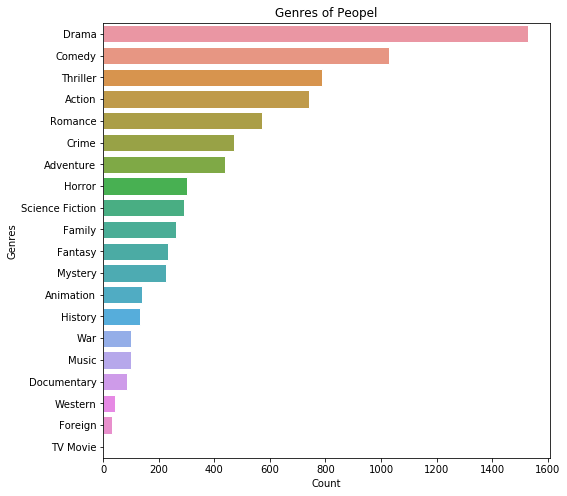

In [0]:
fig, ax = plt.subplots()
fig.set_size_inches(8,8)
sns.set_style("whitegrid")
ax = sns.barplot(x = df['Count'], y =   df.index, data = df)
ax.set(xlabel='Count',ylabel='Genres')
ax.set_title('Genres of Peopel')

In [0]:
df_train['num_genres'] = df_train['genres'].apply(lambda x: len(x) if x != {} else 0)
df_test['num_genres'] = df_test['genres'].apply(lambda x: len(x) if x != {} else 0)

In [0]:
df_train = df_train.drop('genres',axis = 1)
df_test = df_test.drop('genres',axis = 1)

## Production_companies

In [0]:
print('Number of production companies in films')
df_train['production_companies'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of production companies in films


1     775
2     734
3     582
4     312
5     166
0     156
6     118
7      62
8      42
9      29
11      7
10      7
12      3
16      2
15      2
14      1
13      1
17      1
Name: production_companies, dtype: int64

In [0]:
list_of_companies = list(df_train['production_companies'].apply(lambda x : [i['name'] for i in x] if x != {} else []).values)

In [0]:
from collections import Counter
count_name = Counter()
for name in list_of_companies:
  for item in name:
    count_name[item] += 1
#Counter([item for name in list_of_companies for item in name])

In [0]:
count_name.most_common(30)

In [0]:
df_train['num_companies'] = df_train['production_companies'].apply(lambda x: len(x) if x != {} else 0)
df_train['all_production_companies'] = df_train['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_companies = [m[0] for m in Counter([i for j in list_of_companies for i in j]).most_common(30)]
for g in top_companies:
   df_train['production_company_' + g] = df_train['all_production_companies'].apply(lambda x: 1 if g in x else 0)

df_test['num_companies'] = df_test['production_companies'].apply(lambda x: len(x) if x != {} else 0)
df_test['all_production_companies'] = df_test['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_companies:
    df_test['production_company_' + g] = df_test['all_production_companies'].apply(lambda x: 1 if g in x else 0)

df_train = df_train.drop(['production_companies', 'all_production_companies'], axis=1)
df_test = df_test.drop(['production_companies', 'all_production_companies'], axis=1)

## production_countries

In [0]:
for index, value in enumerate(df_train['production_countries'][:5]):
  print(index, value)

0 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
1 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
2 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
3 [{'iso_3166_1': 'IN', 'name': 'India'}]
4 [{'iso_3166_1': 'KR', 'name': 'South Korea'}]


In [0]:
df_train['production_countries'].apply(lambda x : len(x) if x != {} else 0).value_counts()

1    2222
2     525
3     116
4      57
0      55
5      21
6       3
8       1
Name: production_countries, dtype: int64

In [0]:
list_of_countries = list(df_train['production_countries'].apply(lambda x : [i['name'] for i in x] if x!= {} else []).values)

In [0]:
a = Counter(item for name in list_of_countries for item in name).most_common(30)

In [0]:
df_train['num_countries'] = df_train['production_countries'].apply(lambda x : len(x) if x != {} else 0)
df_train['all_countries'] = df_train['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_countries = [m[0] for m in a]
for g in top_countries:
  df_train['production_country_' + g] = df_train['all_countries'].apply(lambda x: 1 if g in x else 0)
  
df_test['num_countries'] = df_test['production_countries'].apply(lambda x: len(x) if x != {} else 0)
df_test['all_countries'] = df_test['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_countries:
  df_test['production_country_' + g] = df_test['all_countries'].apply(lambda x: 1 if g in x else 0)

df_train = df_train.drop(['production_countries', 'all_countries'], axis=1)
df_test = df_test.drop(['production_countries', 'all_countries'], axis=1)

## Spoken languages

In [0]:
for index, value in enumerate(df_train['spoken_languages'][:5]):
  print(index,value)

0 [{'iso_639_1': 'en', 'name': 'English'}]
1 [{'iso_639_1': 'en', 'name': 'English'}]
2 [{'iso_639_1': 'en', 'name': 'English'}]
3 [{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'hi', 'name': 'हिन्दी'}]
4 [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]


In [0]:
df_train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0).value_counts()

1    2105
2     549
3     216
4      72
5      23
0      20
7       6
6       6
8       2
9       1
Name: spoken_languages, dtype: int64

In [0]:
list_of_languages = list(df_train['spoken_languages'].apply(lambda x : [i['name'] for i in x ] if x != {} else []).values)

In [0]:
top_language =  Counter(item for name in list_of_languages for item in name).most_common(30)

In [0]:
df_train['all_language'] = df_train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
df_train['number_language'] = df_train['spoken_languages'].apply(lambda x: ''.join(sorted([i['name'] for i in x])) if x != {} else '')
top_languages = [a[0] for a in top_language] 
for g in top_languages:
  df_train['languages_' + g ] = df_train['all_language'].apply(lambda x : 1 if g in x  else 0)

df_test['num_languages'] = df_test['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
df_test['all_languages'] = df_test['spoken_languages'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_languages:
  df_test['language_' + g] = df_test['all_languages'].apply(lambda x: 1 if g in x else 0)

df_train = df_train.drop(['spoken_languages', 'all_languages'], axis=1)
df_test = df_test.drop(['spoken_languages', 'all_languages'], axis=1)  

## Keywords

In [13]:
for index, value in enumerate(df_train['Keywords'][:5]):
  print(index, value)

0 [{'id': 4379, 'name': 'time travel'}, {'id': 9663, 'name': 'sequel'}, {'id': 11830, 'name': 'hot tub'}, {'id': 179431, 'name': 'duringcreditsstinger'}]
1 [{'id': 2505, 'name': 'coronation'}, {'id': 4263, 'name': 'duty'}, {'id': 6038, 'name': 'marriage'}, {'id': 13072, 'name': 'falling in love'}]
2 [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'name': 'obsession'}, {'id': 1640, 'name': 'conservatory'}, {'id': 2176, 'name': 'music teacher'}, {'id': 14512, 'name': 'new york city'}, {'id': 14819, 'name': 'violence'}, {'id': 33896, 'name': 'montage'}, {'id': 156823, 'name': 'drummer'}, {'id': 170418, 'name': 'public humiliation'}, {'id': 176095, 'name': 'jazz band'}, {'id': 206298, 'name': 'young adult'}, {'id': 207739, 'name': 'music school'}]
3 [{'id': 10092, 'name': 'mystery'}, {'id': 10540, 'name': 'bollywood'}, {'id': 11734, 'name': 'police corruption'}, {'id': 14536, 'name': 'crime'}, {'id': 14636, 'name': 'india'}, {'id': 208364, 'name': 'missing husband'}, {'id': 220935, 'name': 'ne

In [15]:
all_of_keywords = []
for line in df_train['Keywords']:
  array = []
  for item in line:
    array.append(item['name'])
  else:
    all_of_keywords.append(array)
else:
  print(all_of_keywords)

[['time travel', 'sequel', 'hot tub', 'duringcreditsstinger'], ['coronation', 'duty', 'marriage', 'falling in love'], ['jazz', 'obsession', 'conservatory', 'music teacher', 'new york city', 'violence', 'montage', 'drummer', 'public humiliation', 'jazz band', 'young adult', 'music school'], ['mystery', 'bollywood', 'police corruption', 'crime', 'india', 'missing husband', 'nerve gas'], [], [], [], ['journalism', 'translation', 'television', 'manipulation of the media', 'iraq', 'reporter', 'woman director'], ['island', 'pirate gang', 'puppet', 'treasure hunt'], ['mockumentary', 'folk singer'], ['underdog', 'philadelphia', 'transporter', 'italo-american', 'fight', "love of one's life", 'publicity', 'boxer', 'independence', 'boxing match', 'training', 'lovers', 'surprise', 'world champion', 'amateur', 'victory'], ['nerd', 'vacation', 'farce', 'jock', 'frame up', 'defector'], ['male nudity', 'female nudity', 'adultery', 'parent child relationship', 'midlife crisis', 'coming out', 'first tim

In [0]:
all_keywords = list(df_train['Keywords'].apply(lambda x : [i['name'] for i in x ]  if x != {} else "0").values)

In [0]:
all_keywords

In [18]:
print('Number of Keywords in films')
df_train['Keywords'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

Number of Keywords in films


5    293
0    276
4    248
3    228
6    227
2    207
7    192
1    187
8    161
9    134
Name: Keywords, dtype: int64

In [0]:
from collections import Counter

value = Counter(item for name in all_keywords for item in name).most_common(40)
data = pd.DataFrame(data = value, columns=(['Keywords', 'Count']))
data = data.sort_values(by = "Count", ascending = False)

Text(0.5, 1.0, 'All_Of_Keywords')

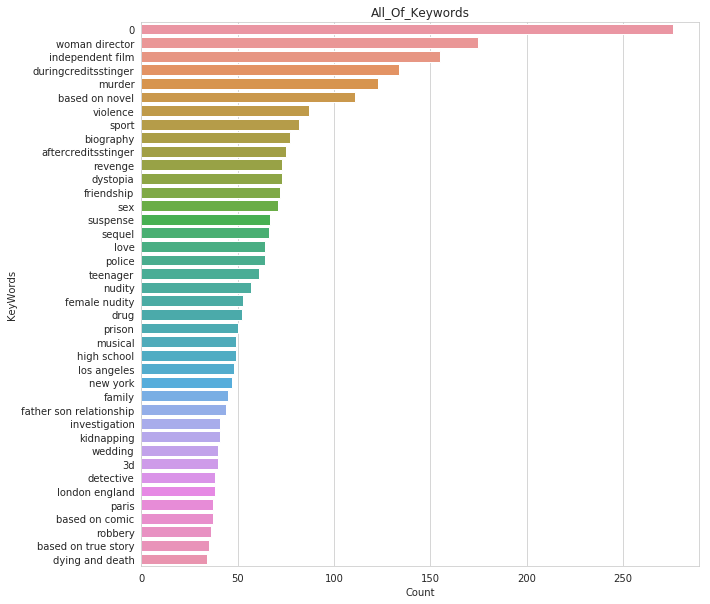

In [123]:
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
sns.set_style("whitegrid")
ax = sns.barplot(x = data['Count'], y = data['Keywords'], data = data)
ax.set(xlabel='Count',ylabel='KeyWords')
ax.set_title('All_Of_Keywords')

In [0]:
df_train['num_keywords']  =  df_train['Keywords'].apply(lambda x : len(x) if x != {} else 0)
df_train['all_Keywords']  =  df_train['Keywords'].apply(lambda x : [i['name'] for i in x] if x != {} else '')
top_keywords = [m[0] for m in Counter(item for name in all_keywords for item in name).most_common(40)]
for g in top_keywords:
  df_train['Keywords_' + g] = df_train['all_Keywords'].apply(lambda x: 1 if g in x else 0)
  
df_test['num_keywords']  =  df_test['Keywords'].apply(lambda x : len(x) if x != {} else 0)
df_test['all_Keywords']  =  df_test['Keywords'].apply(lambda x : [i['name'] for i in x] if x != {} else '')
for g in top_keywords:
  df_test['Keywords_' + g] = df_test['all_Keywords'].apply(lambda x: 1 if g in x else 0)  

df_train = df_train.drop(['Keywords', 'all_Keywords'], axis=1)
df_test = df_test.drop(['Keywords', 'all_Keywords'], axis=1)

## Cast:

In [130]:
for index , value in enumerate(df_train['cast'][:1]):
  print(index, value)


0 [{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847f82afae7', 'gender': 2, 'id': 52997, 'name': 'Rob Corddry', 'order': 0, 'profile_path': '/k2zJL0V1nEZuFT08xUdOd3ucfXz.jpg'}, {'cast_id': 5, 'character': 'Nick', 'credit_id': '52fe4ee7c3a36847f82afaeb', 'gender': 2, 'id': 64342, 'name': 'Craig Robinson', 'order': 1, 'profile_path': '/tVaRMkJXOEVhYxtnnFuhqW0Rjzz.jpg'}, {'cast_id': 6, 'character': 'Jacob', 'credit_id': '52fe4ee7c3a36847f82afaef', 'gender': 2, 'id': 54729, 'name': 'Clark Duke', 'order': 2, 'profile_path': '/oNzK0umwm5Wn0wyEbOy6TVJCSBn.jpg'}, {'cast_id': 7, 'character': 'Adam Jr.', 'credit_id': '52fe4ee7c3a36847f82afaf3', 'gender': 2, 'id': 36801, 'name': 'Adam Scott', 'order': 3, 'profile_path': '/5gb65xz8bzd42yjMAl4zwo4cvKw.jpg'}, {'cast_id': 8, 'character': 'Hot Tub Repairman', 'credit_id': '52fe4ee7c3a36847f82afaf7', 'gender': 2, 'id': 54812, 'name': 'Chevy Chase', 'order': 4, 'profile_path': '/svjpyYtPwtjvRxX9IZnOmOkhDOt.jpg'}, {'cast_id': 9, 'characte

In [0]:
df_train['cast'][0]

In [133]:
print('Number of casted persons in films')
train['cast'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

Number of casted persons in films


15    212
16    165
10    135
13    129
12    124
11    122
9     118
17    118
18    115
14    110
Name: cast, dtype: int64

In [0]:
list_of_cast_name = list(df_train['cast'].apply(lambda x : [i['name'] for i in x]  if x != {} else []).values)
top_name = Counter([name for names in list_of_cast_name for name in names])

In [0]:
top = top_name.most_common(15)

In [0]:
from PIL import Image
from urllib.request import urlopen

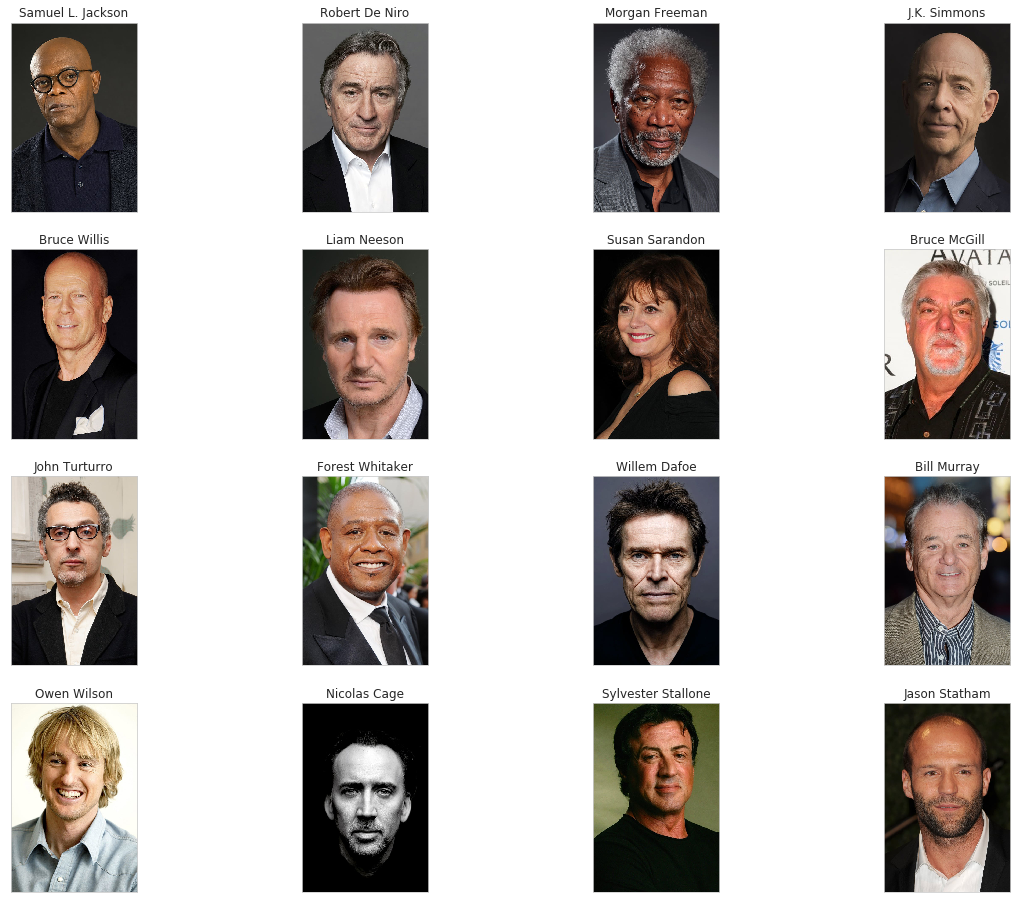

In [154]:
list_of_cast_nameurl = list(train['cast'].apply(lambda x: [(i['name'], i['profile_path']) for i in x] if x != {} else []).values)
c = Counter([i for j in list_of_cast_nameurl for i in j]).most_common(16)
fig = plt.figure(figsize=(20,16))
for name, pic in enumerate([name[0] for name in c ]):
  ax = fig.add_subplot(4, 4, name+1, xticks=[], yticks=[])
  img = Image.open(urlopen(f"https://image.tmdb.org/t/p/w600_and_h900_bestv2{pic[1]}"))
  plt.imshow(img)
  ax.set_title(f'{pic[0]}')

In [174]:
fig = plt.figure(figsize=(10,10))
for name, pic in enumerate([name[0] for name in c]):
  ax = fig.add_subplot(4,4 , name + 1 , xticks=[], yticks=[])
  img = Image.open(urlopen(f"https://image.tmdb.org/t/p/w600_and_h900_bestv2{pic[1]}"))
  plt.imshow(img)
  ax.set_title(f'{pic[0]}')

SyntaxError: ignored

In [178]:
for name , pic in enumerate([name[0] for name in c]):
  print(F'{pic[0]}')

Samuel L. Jackson
Robert De Niro
Morgan Freeman
J.K. Simmons
Bruce Willis
Liam Neeson
Susan Sarandon
Bruce McGill
John Turturro
Forest Whitaker
Willem Dafoe
Bill Murray
Owen Wilson
Nicolas Cage
Sylvester Stallone
Jason Statham
